In [5]:
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [6]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))



In [7]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

def _preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
  return image, image

train_dataset = (datasets['train']
                 .map(_preprocess)
                 .batch(256)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))
eval_dataset = (datasets['test']
                .map(_preprocess)
                .batch(256)
                .prefetch(tf.data.experimental.AUTOTUNE))

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [8]:
input_shape = datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [9]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

_ = vae.fit(train_dataset,
            epochs=15,
            validation_data=eval_dataset)

Epoch 1/15
235/235 [==============================] - 383s 2s/step - loss: 213.8945 - val_loss: 162.5539
Epoch 2/15
235/235 [==============================] - 453s 2s/step - loss: 152.3995 - val_loss: 147.1221
Epoch 3/15
235/235 [==============================] - 568s 2s/step - loss: 142.4335 - val_loss: 139.6141
Epoch 4/15
235/235 [==============================] - 569s 2s/step - loss: 136.2854 - val_loss: 132.0612
Epoch 5/15
235/235 [==============================] - 573s 2s/step - loss: 130.1365 - val_loss: 126.6525
Epoch 6/15
235/235 [==============================] - 561s 2s/step - loss: 126.3523 - val_loss: 124.5257
Epoch 7/15
235/235 [==============================] - 572s 2s/step - loss: 124.1631 - val_loss: 122.8507
Epoch 8/15
235/235 [==============================] - 504s 2s/step - loss: 122.7216 - val_loss: 121.2935
Epoch 9/15
235/235 [==============================] - 565s 2s/step - loss: 121.7109 - val_loss: 121.0516
Epoch 10/15
235/235 [==============================] - 

Originals:


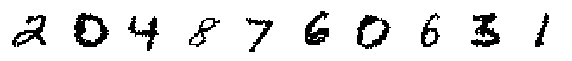

Decoded Random Samples:


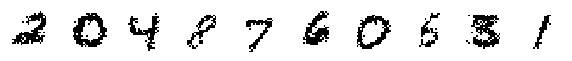

Decoded Modes:


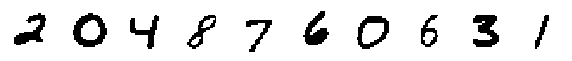

Decoded Means:


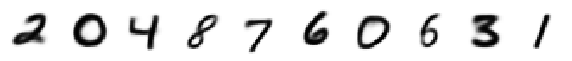

In [12]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib.pyplot as plt

def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

Randomly Generated Samples:


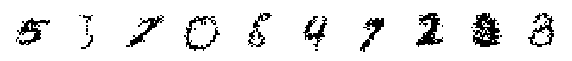

Randomly Generated Modes:


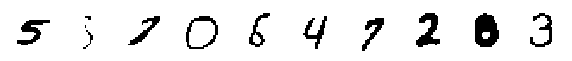

Randomly Generated Means:


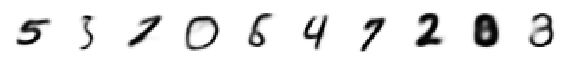

In [13]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfd.Distribution)

print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())